In [25]:
pip install pandas numpy faker

Note: you may need to restart the kernel to use updated packages.


In [26]:
!pip install matplotlib seaborn

In [27]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import random
import uuid
from typing import List, Dict
import os

# Initialize Faker
fake = Faker()

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

class EventDataGenerator:
    def __init__(self, num_events: int = 100, num_users: int = 1000):
        self.num_events = num_events
        self.num_users = num_users
        self.event_categories = ['Music', 'Sports', 'Education', 'Technology', 'Arts', 'Food', 
                               'Business', 'Health', 'Community', 'Entertainment']
        self.interests = ['yoga', 'coding', 'music', 'sports', 'art', 'food', 'technology', 
                         'education', 'networking', 'fitness', 'photography', 'writing']
        self.accessibility_features = ['wheelchair_access', 'sign_language', 'virtual_attendance', 
                                     'hearing_loop', 'accessible_parking', 'braille']
        self.tags = ['family-friendly', 'free', 'outdoor', 'indoor', 'beginner-friendly', 
                    'professional', 'hands-on', 'interactive', 'networking', 'food-provided']

    def generate_user_data(self) -> pd.DataFrame:
        users = []
        for _ in range(self.num_users):
            user_interests = random.sample(self.interests, random.randint(2, 5))
            users.append({
                'user_id': str(uuid.uuid4()),
                'interests': user_interests
            })
        return pd.DataFrame(users)

    def generate_event_data(self) -> pd.DataFrame:
        events = []
        current_date = datetime.now()
        
        for _ in range(self.num_events):
            # Generate event timing
            start_date = current_date + timedelta(days=random.randint(1, 365))
            duration_hours = random.randint(1, 8)
            end_date = start_date + timedelta(hours=duration_hours)
            
            # Generate location data
            latitude = fake.latitude()
            longitude = fake.longitude()
            
            # Generate price data
            is_free = random.random() < 0.3
            price = 0 if is_free else round(random.uniform(10, 200), 2)
            
            # Generate accessibility features
            accessibility = random.sample(self.accessibility_features, random.randint(1, 3))
            
            # Generate tags
            event_tags = random.sample(self.tags, random.randint(2, 5))
            
            event = {
                'event_id': str(uuid.uuid4()),
                'event_name': fake.catch_phrase(),
                'category': random.choice(self.event_categories),
                'description': fake.text(max_nb_chars=200),
                'start_datetime': start_date,
                'end_datetime': end_date,
                'duration_hours': duration_hours,
                'venue_name': fake.company(),
                'address': fake.address(),
                'latitude': latitude,
                'longitude': longitude,
                'city': fake.city(),
                'region': fake.state(),
                'price': price,
                'accessibility_features': accessibility,
                'tags': event_tags,
                'image_url': f"https://example.com/images/{fake.uuid4()}.jpg",
                'video_url': f"https://example.com/videos/{fake.uuid4()}.mp4" if random.random() < 0.3 else None,
                'created_date': current_date - timedelta(days=random.randint(1, 30)),
                'last_updated_date': current_date - timedelta(days=random.randint(0, 7))
            }
            events.append(event)
            
        return pd.DataFrame(events)

    def generate_user_engagement(self, events_df: pd.DataFrame, users_df: pd.DataFrame) -> pd.DataFrame:
        engagements = []
        
        # Generate multiple engagements per event to reach 20000+ values
        total_engagements_needed = 20000
        engagements_per_event = total_engagements_needed // self.num_events + 1
        
        for event_id in events_df['event_id']:
            for _ in range(engagements_per_event):
                user = random.choice(users_df['user_id'].values)
                
                engagement = {
                    'event_id': event_id,
                    'user_id': user,
                    'rating': random.randint(1, 5),
                    'engagement_type': random.choice(['click', 'share', 'save']),
                    'attendance_status': random.choice(['attending', 'maybe', 'not_attending']),
                    'review': fake.text(max_nb_chars=100) if random.random() < 0.3 else None,
                    'engagement_date': datetime.now() - timedelta(days=random.randint(0, 30))
                }
                engagements.append(engagement)
        
        return pd.DataFrame(engagements)

    def calculate_popularity_scores(self, events_df: pd.DataFrame, engagements_df: pd.DataFrame) -> pd.DataFrame:
        # Calculate attendance count
        attendance_count = engagements_df[engagements_df['attendance_status'] == 'attending'].groupby('event_id').size()
        
        # Calculate average rating
        avg_ratings = engagements_df.groupby('event_id')['rating'].mean()
        
        # Calculate engagement score
        engagement_counts = engagements_df.groupby('event_id').size()
        
        # Combine metrics into popularity score (normalized to 0-100 scale)
        events_df['attendance_count'] = events_df['event_id'].map(attendance_count).fillna(0)
        events_df['avg_rating'] = events_df['event_id'].map(avg_ratings).fillna(0)
        events_df['engagement_count'] = events_df['event_id'].map(engagement_counts).fillna(0)
        
        # Normalize and combine scores
        events_df['popularity_score'] = (
            (events_df['attendance_count'] / events_df['attendance_count'].max() * 40) +
            (events_df['avg_rating'] / 5 * 40) +
            (events_df['engagement_count'] / events_df['engagement_count'].max() * 20)
        ).round(2)
        
        return events_df

    def generate_complete_dataset(self) -> Dict[str, pd.DataFrame]:
        # Generate base data
        users_df = self.generate_user_data()
        events_df = self.generate_event_data()
        engagements_df = self.generate_user_engagement(events_df, users_df)
        
        # Calculate popularity scores and update events
        events_df = self.calculate_popularity_scores(events_df, engagements_df)
        
        return {
            'events': events_df,
            'users': users_df,
            'engagements': engagements_df
        }

def save_dataset(dataset: Dict[str, pd.DataFrame], kaggle_output_dir: str = '/kaggle/working/') -> None:
    """Save the generated dataset to CSV files in Kaggle working directory."""
    # Create the output directory if it doesn't exist
    os.makedirs(kaggle_output_dir, exist_ok=True)
    
    for name, df in dataset.items():
        output_path = os.path.join(kaggle_output_dir, f"{name}.csv")
        df.to_csv(output_path, index=False)
        print(f"Saved {name}.csv with {len(df)} records to {output_path}")

# Generate and save the dataset
if __name__ == "__main__":
    try:
        # Generate the dataset
        generator = EventDataGenerator(num_events=100, num_users=1000)
        dataset = generator.generate_complete_dataset()
        
        # Save to Kaggle working directory
        save_dataset(dataset)
        
        print("\nDataset generation complete!")
        print(f"Total number of records generated:")
        for name, df in dataset.items():
            print(f"- {name}: {len(df)} records")
            
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Saved events.csv with 100 records to /kaggle/working/events.csv
Saved users.csv with 1000 records to /kaggle/working/users.csv
Saved engagements.csv with 20100 records to /kaggle/working/engagements.csv

Dataset generation complete!
Total number of records generated:
- events: 100 records
- users: 1000 records
- engagements: 20100 records


In [28]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

class EventNLPProcessor:
    def __init__(self, events_df: pd.DataFrame):
        """
        Initialize NLP processor with events data
        
        Args:
            events_df: DataFrame containing events data
        """
        self.events_df = events_df
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')
        
        # Extract unique categories and tags for entity matching
        self.categories = set(events_df['category'].unique())
        self.all_tags = set([tag for tags in events_df['tags'] for tag in eval(tags)])
        
    def process_query(self, query: str) -> Dict:
        """
        Process natural language query to extract intent and entities
        
        Args:
            query: User's natural language query
            
        Returns:
            Dictionary containing intent, entities, and query embedding
        """
        # Tokenize and get BERT embeddings
        inputs = self.tokenizer(query, 
                              return_tensors="pt", 
                              padding=True, 
                              truncation=True,
                              max_length=128)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        
        # Extract intent and entities
        intent = self._classify_intent(query.lower())
        entities = self._extract_entities(query.lower())
        
        return {
            'intent': intent,
            'entities': entities,
            'embedding': embeddings.numpy(),
            'processed_query': self._process_query_to_filters(entities)
        }
    
    def _classify_intent(self, query: str) -> str:
        """Classify user intent based on query keywords"""
        intent_patterns = {
            'search': ['find', 'search', 'look', 'show', 'near'],
            'details': ['tell me about', 'what is', 'details', 'information'],
            'register': ['register', 'sign up', 'book', 'attend'],
            'feedback': ['rate', 'review', 'feedback']
        }
        
        for intent, patterns in intent_patterns.items():
            if any(pattern in query for pattern in patterns):
                return intent
        return 'search'  # default intent
    
    def _extract_entities(self, query: str) -> Dict:
        """Extract relevant entities from the query"""
        words = query.split()
        entities = {
            'category': [],
            'location': [],
            'date': [],
            'tags': [],
            'price': None
        }
        
        # Date patterns
        date_keywords = {'today', 'tomorrow', 'weekend', 'next week', 'this week'}
        
        # Price patterns
        price_keywords = {'free', 'paid', 'cheap', 'expensive'}
        
        for i, word in enumerate(words):
            # Match categories
            if word in self.categories:
                entities['category'].append(word)
                
            # Match tags
            if word in self.all_tags:
                entities['tags'].append(word)
                
            # Extract locations (simple approach - could be enhanced with NER)
            if word in ['in', 'at', 'near']:
                if i + 1 < len(words):
                    entities['location'].append(words[i + 1])
                    
            # Extract dates
            if word in date_keywords:
                entities['date'].append(word)
                
            # Extract price preferences
            if word in price_keywords:
                entities['price'] = word
                
        return entities
    
    def _process_query_to_filters(self, entities: Dict) -> Dict:
        """Convert extracted entities to filtering parameters"""
        filters = {}
        
        if entities['category']:
            filters['category'] = entities['category']
            
        if entities['tags']:
            filters['tags'] = entities['tags']
            
        if entities['location']:
            filters['location'] = entities['location']
            
        if entities['price']:
            filters['price'] = entities['price']
            
        if entities['date']:
            filters['date'] = entities['date']
            
        return filters

# Example usage
def main():
    # Load events dataset
    events_df = pd.read_csv('/kaggle/working/events.csv')
    
    # Initialize NLP processor
    nlp_processor = EventNLPProcessor(events_df)
    
    # Test queries
    test_queries = [
        "Find yoga classes near New York",
        "Show me free music events this weekend",
        "What are the technology conferences next week?",
        "Tell me about outdoor events in Chicago"
    ]
    
    # Process each query and print results
    for query in test_queries:
        print(f"\nProcessing query: {query}")
        results = nlp_processor.process_query(query)
        print("Intent:", results['intent'])
        print("Entities:", results['entities'])
        print("Filters:", results['processed_query'])

if __name__ == "__main__":
    main()


Processing query: Find yoga classes near New York
Intent: search
Entities: {'category': [], 'location': ['new'], 'date': [], 'tags': [], 'price': None}
Filters: {'location': ['new']}

Processing query: Show me free music events this weekend
Intent: search
Entities: {'category': [], 'location': [], 'date': ['weekend'], 'tags': ['free'], 'price': 'free'}
Filters: {'tags': ['free'], 'price': 'free', 'date': ['weekend']}

Processing query: What are the technology conferences next week?
Intent: search
Entities: {'category': [], 'location': [], 'date': [], 'tags': [], 'price': None}
Filters: {}

Processing query: Tell me about outdoor events in Chicago
Intent: details
Entities: {'category': [], 'location': ['chicago'], 'date': [], 'tags': ['outdoor'], 'price': None}
Filters: {'tags': ['outdoor'], 'location': ['chicago']}


In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict, Tuple
import logging

class EventRecommender:
    def __init__(self, events_df: pd.DataFrame, users_df: pd.DataFrame, engagements_df: pd.DataFrame):
        """Initialize the recommendation engine with required datasets"""
        self.events_df = events_df
        self.users_df = users_df
        self.engagements_df = engagements_df
        
        # Set up logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
        # Add debug logging
        self.logger.info(f"Loaded {len(events_df)} events, {len(users_df)} users, {len(engagements_df)} engagements")
        
        # Initialize recommendation components
        self._setup_collaborative_filtering()
        self._setup_content_based_filtering()

    def _setup_collaborative_filtering(self):
        """Initialize user-item interaction matrix for collaborative filtering"""
        try:
            # Add debug logging
            self.logger.info("Setting up collaborative filtering...")
            
            # Create user-item interaction matrix
            self.user_item_matrix = pd.pivot_table(
                self.engagements_df,
                values='rating',
                index='user_id',
                columns='event_id',
                fill_value=0
            )
            
            # Handle cold start - if matrix is empty
            if self.user_item_matrix.empty:
                self.logger.warning("User-item matrix is empty. Check if engagements data contains ratings.")
                return
            
            # Calculate user similarity matrix using pearson correlation
            self.user_similarity = self.user_item_matrix.T.corr(method='pearson')
            
            self.logger.info(f"Created user-item matrix with shape {self.user_item_matrix.shape}")
            
        except Exception as e:
            self.logger.error(f"Error setting up collaborative filtering: {str(e)}")
            raise

    def _setup_content_based_filtering(self):
        """Initialize content-based filtering components"""
        try:
            # Add debug logging
            self.logger.info("Setting up content-based filtering...")
            
            # Safely combine text features with error handling for tags
            def combine_features(row):
                try:
                    tags = eval(row['tags']) if isinstance(row['tags'], str) else []
                except:
                    tags = []
                return f"{row['category']} {row['description']} {' '.join(tags)}"
            
            self.events_df['combined_features'] = self.events_df.apply(combine_features, axis=1)
            
            # Create TF-IDF vectors
            self.tfidf = TfidfVectorizer(stop_words='english')
            self.event_vectors = self.tfidf.fit_transform(self.events_df['combined_features'])
            
            self.logger.info(f"Created TF-IDF vectors with shape {self.event_vectors.shape}")
            
        except Exception as e:
            self.logger.error(f"Error setting up content-based filtering: {str(e)}")
            raise

    def get_collaborative_recommendations(self, user_id: str, n_recommendations: int = 5) -> List[Dict]:
        """Get recommendations based on collaborative filtering"""
        try:
            # Check if user exists in matrix
            if user_id not in self.user_item_matrix.index:
                self.logger.warning(f"User {user_id} not found in user-item matrix")
                return []
            
            # Get user's rated items
            user_ratings = self.user_item_matrix.loc[user_id]
            user_rated_items = set(user_ratings[user_ratings > 0].index)
            
            # Find similar users
            if user_id not in self.user_similarity.index:
                self.logger.warning(f"User {user_id} not found in similarity matrix")
                return []
                
            similar_users = self.user_similarity[user_id].sort_values(ascending=False)[1:11]  # Get top 10 similar users
            
            # Get recommendations from similar users
            recommended_events = []
            seen_events = set()
            
            for similar_user in similar_users.index:
                # Get items rated highly by similar user
                similar_user_ratings = self.user_item_matrix.loc[similar_user]
                liked_events = similar_user_ratings[similar_user_ratings >= 4].index
                
                for event_id in liked_events:
                    if event_id not in user_rated_items and event_id not in seen_events:
                        event_data = self.events_df[self.events_df['event_id'] == event_id]
                        if not event_data.empty:
                            event_data = event_data.iloc[0]
                            recommended_events.append({
                                'event_id': event_id,
                                'name': event_data['event_name'],
                                'category': event_data['category'],
                                'score': float(similar_user_ratings[event_id])
                            })
                            seen_events.add(event_id)
                            
                        if len(recommended_events) >= n_recommendations:
                            break
                            
                if len(recommended_events) >= n_recommendations:
                    break
            
            return recommended_events[:n_recommendations]
            
        except Exception as e:
            self.logger.error(f"Error in collaborative recommendations: {str(e)}")
            return []

    def get_content_recommendations(self, event_id: str, n_recommendations: int = 5) -> List[Dict]:
        """Get recommendations based on content similarity"""
        try:
            # Get event index
            event_mask = self.events_df['event_id'] == event_id
            if not any(event_mask):
                self.logger.warning(f"Event {event_id} not found")
                return []
                
            event_idx = event_mask.idxmax()
            event_vector = self.event_vectors[event_idx]
            
            # Calculate similarities
            similarities = cosine_similarity(event_vector, self.event_vectors).flatten()
            similar_indices = similarities.argsort()[::-1][1:n_recommendations+1]
            
            # Get recommended events
            recommendations = []
            for idx in similar_indices:
                event_data = self.events_df.iloc[idx]
                recommendations.append({
                    'event_id': event_data['event_id'],
                    'name': event_data['event_name'],
                    'category': event_data['category'],
                    'similarity_score': float(similarities[idx])
                })
                
            return recommendations
            
        except Exception as e:
            self.logger.error(f"Error in content recommendations: {str(e)}")
            return []

    def get_hybrid_recommendations(self, user_id: str, n_recommendations: int = 5) -> List[Dict]:
        """Get hybrid recommendations combining collaborative and content-based approaches"""
        try:
            # Get collaborative recommendations
            collaborative_recs = self.get_collaborative_recommendations(user_id, n_recommendations)
            
            # Get user's previous interactions
            user_events = self.engagements_df[
                (self.engagements_df['user_id'] == user_id) & 
                (self.engagements_df['rating'] >= 4)
            ].sort_values('rating', ascending=False)
            
            content_recs = []
            if not user_events.empty:
                favorite_event = user_events.iloc[0]['event_id']
                content_recs = self.get_content_recommendations(favorite_event, n_recommendations)
            
            # Combine recommendations with weights
            hybrid_recs = []
            seen_events = set()
            
            # Alternate between collaborative and content-based with more weight to collaborative
            while len(hybrid_recs) < n_recommendations and (collaborative_recs or content_recs):
                if collaborative_recs:
                    rec = collaborative_recs.pop(0)
                    if rec['event_id'] not in seen_events:
                        hybrid_recs.append(rec)
                        seen_events.add(rec['event_id'])
                
                if len(hybrid_recs) < n_recommendations and content_recs:
                    rec = content_recs.pop(0)
                    if rec['event_id'] not in seen_events:
                        hybrid_recs.append(rec)
                        seen_events.add(rec['event_id'])
            
            return hybrid_recs[:n_recommendations]
            
        except Exception as e:
            self.logger.error(f"Error in hybrid recommendations: {str(e)}")
            return []

# Example usage with improved debugging
def main():
    try:
        # Load datasets
        events_df = pd.read_csv('/kaggle/working/events.csv')
        users_df = pd.read_csv('/kaggle/working/users.csv')
        engagements_df = pd.read_csv('/kaggle/working/engagements.csv')
        
        # Print dataset info
        print("\nDataset Information:")
        print(f"Events: {len(events_df)} records")
        print(f"Users: {len(users_df)} records")
        print(f"Engagements: {len(engagements_df)} records")
        
        # Initialize recommender
        recommender = EventRecommender(events_df, users_df, engagements_df)
        
        # Get sample user with engagements
        users_with_engagements = engagements_df['user_id'].unique()
        if len(users_with_engagements) > 0:
            sample_user_id = users_with_engagements[0]
            print(f"\nTesting with user_id: {sample_user_id}")
            
            # Get recommendations
            print("\nCollaborative Filtering Recommendations:")
            collab_recs = recommender.get_collaborative_recommendations(sample_user_id)
            print(collab_recs)
            
            # Get a sample event for content-based recommendations
            if len(events_df) > 0:
                sample_event_id = events_df['event_id'].iloc[0]
                print("\nContent-Based Recommendations:")
                content_recs = recommender.get_content_recommendations(sample_event_id)
                print(content_recs)
            
            print("\nHybrid Recommendations:")
            hybrid_recs = recommender.get_hybrid_recommendations(sample_user_id)
            print(hybrid_recs)
        else:
            print("No users with engagements found in the dataset")
            
    except Exception as e:
        print(f"Error in main: {str(e)}")

if __name__ == "__main__":
    main()


Dataset Information:
Events: 100 records
Users: 1000 records
Engagements: 20100 records

Testing with user_id: fc60e45c-21ee-4f01-b7b8-9867be658ef9

Collaborative Filtering Recommendations:
[{'event_id': 'f6e70751-25f6-4b1e-bdda-6490f4746c91', 'name': 'Total encompassing instruction set', 'category': 'Health', 'score': 5.0}, {'event_id': '66c1eaca-d444-461a-99ac-0f4343200566', 'name': 'Public-key grid-enabled circuit', 'category': 'Education', 'score': 5.0}, {'event_id': 'd17242ab-3847-475b-a793-7ceafcfab573', 'name': 'Multi-layered non-volatile migration', 'category': 'Music', 'score': 5.0}, {'event_id': '089153fe-9c7b-4ce9-8bff-00967264333c', 'name': 'Intuitive hybrid productivity', 'category': 'Technology', 'score': 5.0}, {'event_id': 'd8d2e5a7-b8d2-4f99-ba5c-7cb0eeb3c202', 'name': 'Stand-alone regional alliance', 'category': 'Music', 'score': 5.0}]

Content-Based Recommendations:
[{'event_id': '3e9739eb-ebe1-4c7b-a548-5fe6100c4850', 'name': 'Devolved bandwidth-monitored middleware


Dataset Summary:
Total Events: 100
Total Users: 1000
Total Engagements: 20100

Plotting recommendations for user: b1f2171c-9982-4cb1-83dc-f6938a73add9


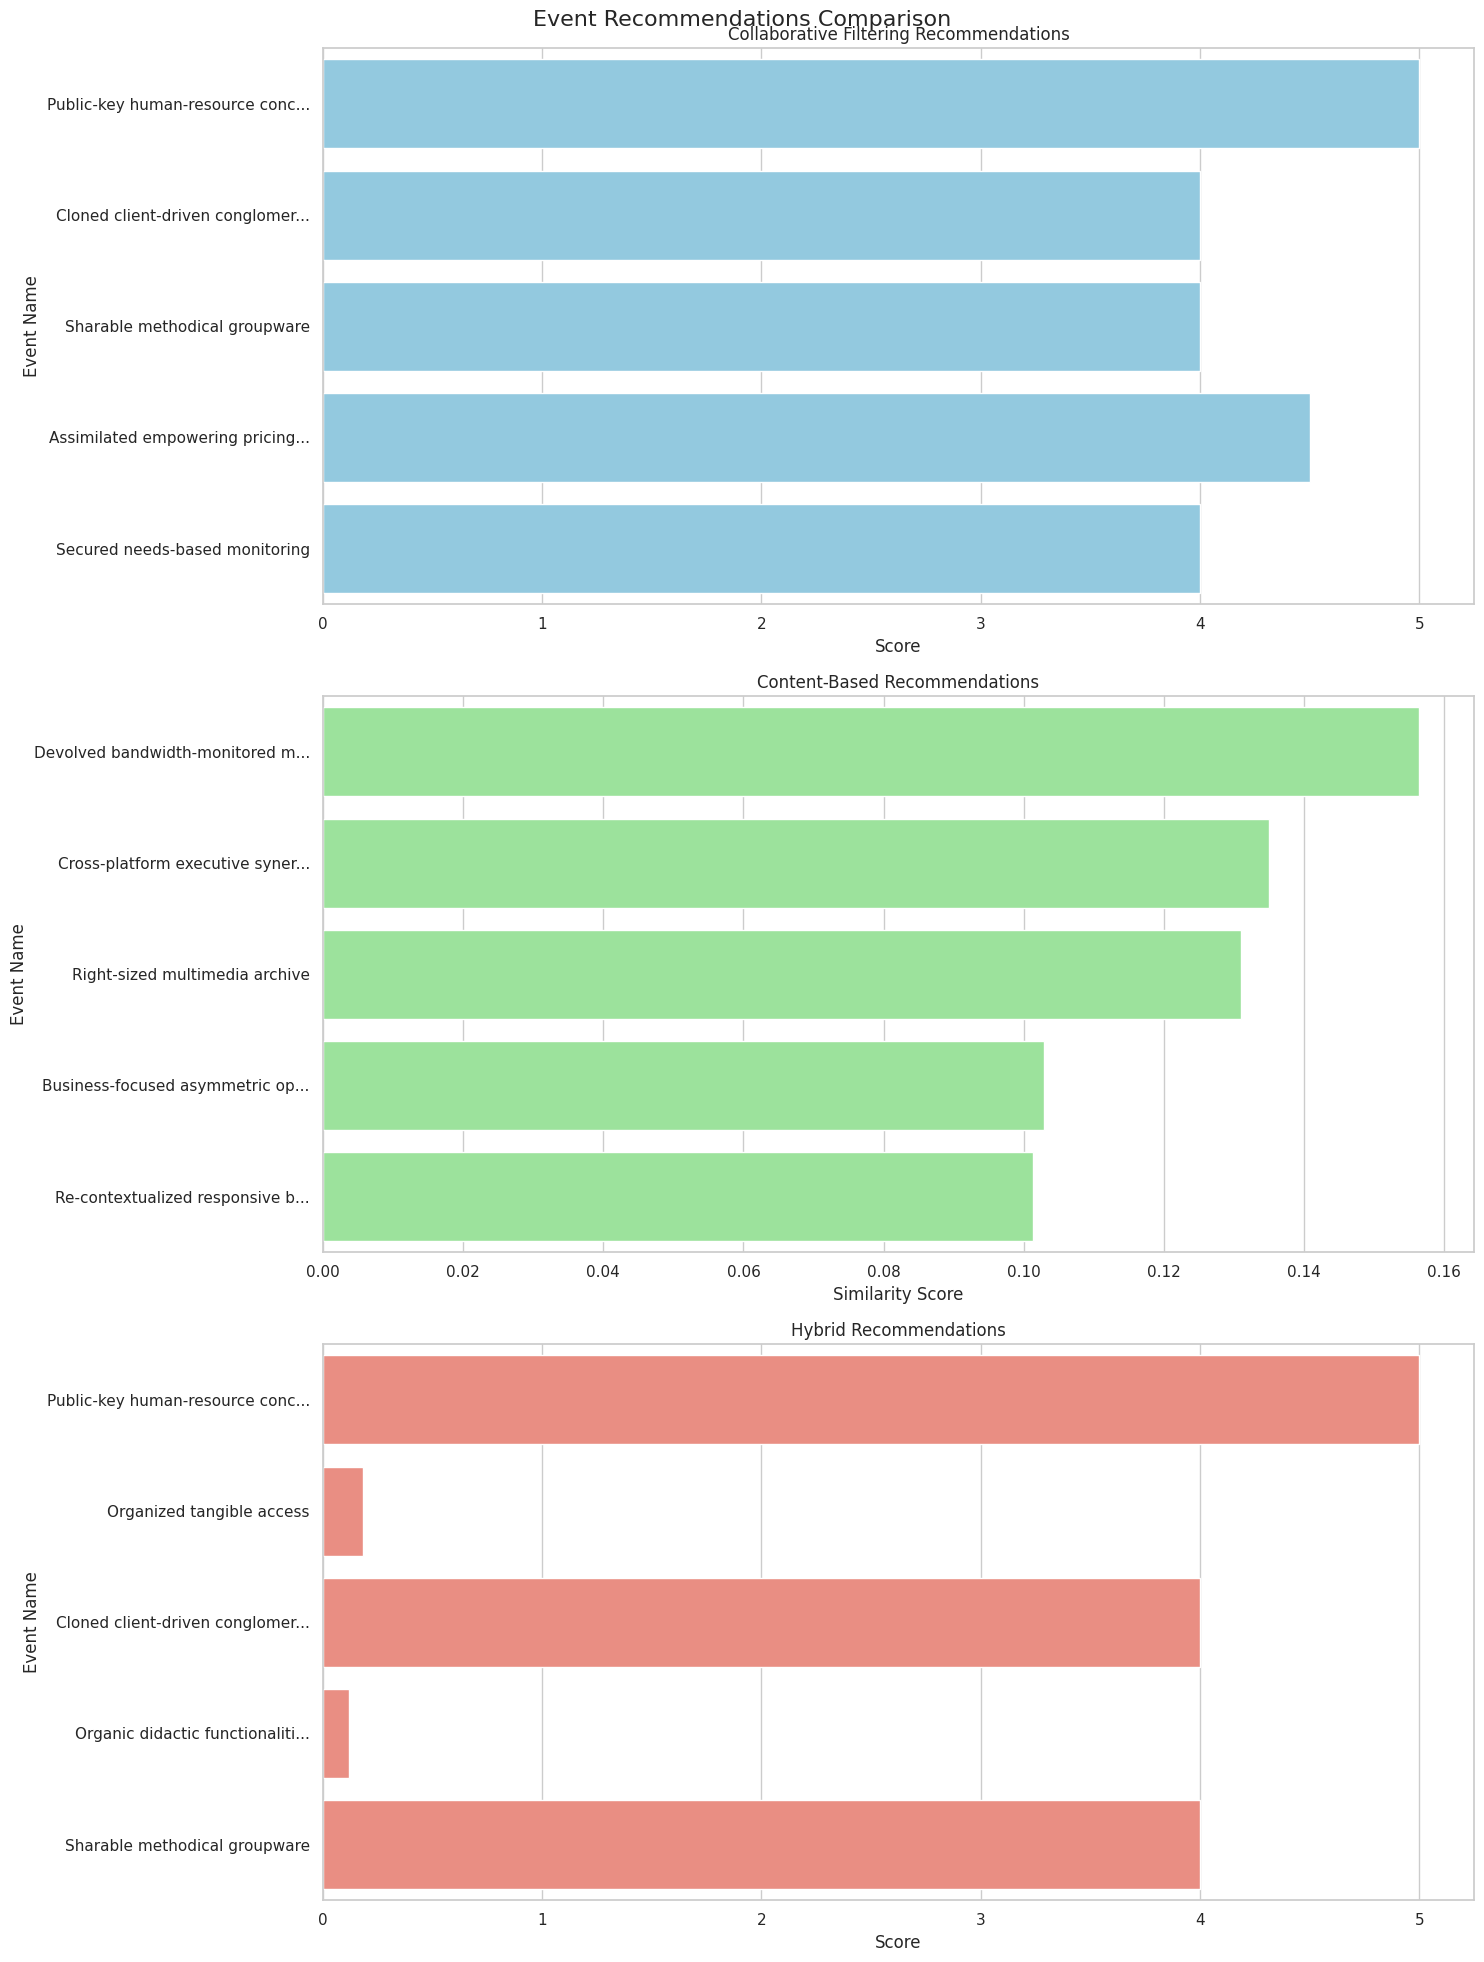

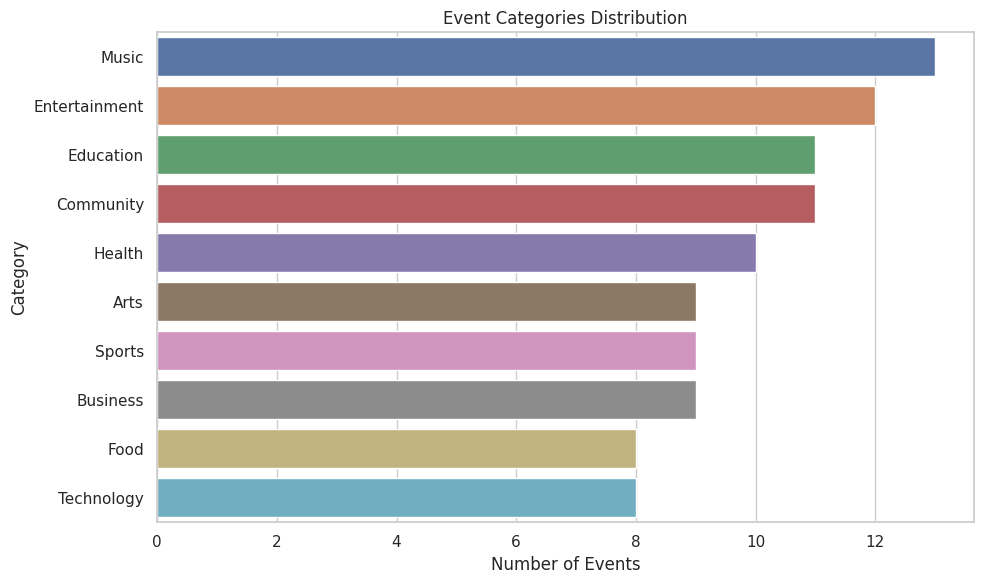

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_recommendations(recommender, user_id):
    """
    Plot bar charts for all recommendation types
    """
    # Get recommendations
    collab_recs = recommender.get_collaborative_recommendations(user_id)
    content_recs = recommender.get_content_recommendations(
        recommender.events_df['event_id'].iloc[0]
    )
    hybrid_recs = recommender.get_hybrid_recommendations(user_id)
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 20))
    fig.suptitle('Event Recommendations Comparison', fontsize=16)
    
    # Plot Collaborative Filtering recommendations
    if collab_recs:
        names = [rec['name'][:30] + '...' if len(rec['name']) > 30 else rec['name'] 
                for rec in collab_recs]
        scores = [rec['score'] for rec in collab_recs]
        sns.barplot(x=scores, y=names, ax=axes[0], color='skyblue')
        axes[0].set_title('Collaborative Filtering Recommendations')
        axes[0].set_xlabel('Score')
        axes[0].set_ylabel('Event Name')
    
    # Plot Content-based recommendations
    if content_recs:
        names = [rec['name'][:30] + '...' if len(rec['name']) > 30 else rec['name'] 
                for rec in content_recs]
        scores = [rec['similarity_score'] for rec in content_recs]
        sns.barplot(x=scores, y=names, ax=axes[1], color='lightgreen')
        axes[1].set_title('Content-Based Recommendations')
        axes[1].set_xlabel('Similarity Score')
        axes[1].set_ylabel('Event Name')
    
    # Plot Hybrid recommendations
    if hybrid_recs:
        names = [rec['name'][:30] + '...' if len(rec['name']) > 30 else rec['name'] 
                for rec in hybrid_recs]
        scores = [rec.get('score', rec.get('similarity_score', 0)) for rec in hybrid_recs]
        sns.barplot(x=scores, y=names, ax=axes[2], color='salmon')
        axes[2].set_title('Hybrid Recommendations')
        axes[2].set_xlabel('Score')
        axes[2].set_ylabel('Event Name')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_category_breakdown(recommender):
    """
    Plot category distribution of events
    """
    plt.figure(figsize=(10, 6))
    category_counts = recommender.events_df['category'].value_counts()
    sns.barplot(x=category_counts.values, y=category_counts.index)
    plt.title('Event Categories Distribution')
    plt.xlabel('Number of Events')
    plt.ylabel('Category')
    plt.tight_layout()
    plt.show()

# Example usage
def main():
    try:
        # Load datasets
        events_df = pd.read_csv('/kaggle/working/events.csv')
        users_df = pd.read_csv('/kaggle/working/users.csv')
        engagements_df = pd.read_csv('/kaggle/working/engagements.csv')
        
        # Initialize recommender
        recommender = EventRecommender(events_df, users_df, engagements_df)
        
        # Get a sample user
        sample_user_id = users_df['user_id'].iloc[0]
        
        # Print summary stats
        print("\nDataset Summary:")
        print(f"Total Events: {len(events_df)}")
        print(f"Total Users: {len(users_df)}")
        print(f"Total Engagements: {len(engagements_df)}")
        print(f"\nPlotting recommendations for user: {sample_user_id}")
        
        # Create visualizations
        plot_recommendations(recommender, sample_user_id)
        plot_category_breakdown(recommender)
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [31]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from geopy.distance import geodesic
import logging

def debug_location_discovery(events_df, users_df, engagements_df):
    """Debug function to analyze event discovery issues"""
    print("\n=== Debug Information ===")
    
    # 1. Check dataframes are loaded properly
    print("\nDataframe Sizes:")
    print(f"Events DataFrame: {events_df.shape}")
    print(f"Users DataFrame: {users_df.shape}")
    print(f"Engagements DataFrame: {engagements_df.shape}")
    
    # 2. Check for required columns
    print("\nEvents DataFrame Columns:")
    print(events_df.columns.tolist())
    
    # 3. Check location data
    print("\nLocation Data Statistics:")
    if 'latitude' in events_df.columns and 'longitude' in events_df.columns:
        print("\nLatitude range:", events_df['latitude'].min(), "to", events_df['latitude'].max())
        print("Longitude range:", events_df['longitude'].min(), "to", events_df['longitude'].max())
        print("\nNull coordinates:", events_df[['latitude', 'longitude']].isnull().sum())
    else:
        print("Warning: Missing latitude/longitude columns!")
    
    # 4. Check city and region data
    print("\nCity and Region Statistics:")
    if 'city' in events_df.columns:
        print("\nUnique cities:", events_df['city'].nunique())
        print("\nSample cities (first 5):")
        print(events_df['city'].value_counts().head())
    
    if 'region' in events_df.columns:
        print("\nUnique regions:", events_df['region'].nunique())
        print("\nSample regions (first 5):")
        print(events_df['region'].value_counts().head())
    
    # 5. Test specific searches
    test_coords = (-21.5216505, -40.867424)
    print(f"\nEvents within 50km of test coordinates {test_coords}:")
    nearby_count = 0
    if 'latitude' in events_df.columns and 'longitude' in events_df.columns:
        for _, event in events_df.iterrows():
            distance = geodesic(test_coords, (event['latitude'], event['longitude'])).kilometers
            if distance <= 50:
                nearby_count += 1
                if nearby_count <= 5:  # Show first 5 nearby events
                    print(f"Distance: {distance:.2f}km - {event['event_name']} at {event['venue_name']}")
        print(f"Total nearby events: {nearby_count}")

def main():
    try:
        # Load data
        events_df = pd.read_csv('/kaggle/working/events.csv')
        users_df = pd.read_csv('/kaggle/working/users.csv')
        engagements_df = pd.read_csv('/kaggle/working/engagements.csv')
        
        # Run debug analysis
        debug_location_discovery(events_df, users_df, engagements_df)
        
    except Exception as e:
        print(f"Error in debug main: {str(e)}")

if __name__ == "__main__":
    main()


=== Debug Information ===

Dataframe Sizes:
Events DataFrame: (100, 24)
Users DataFrame: (1000, 2)
Engagements DataFrame: (20100, 7)

Events DataFrame Columns:
['event_id', 'event_name', 'category', 'description', 'start_datetime', 'end_datetime', 'duration_hours', 'venue_name', 'address', 'latitude', 'longitude', 'city', 'region', 'price', 'accessibility_features', 'tags', 'image_url', 'video_url', 'created_date', 'last_updated_date', 'attendance_count', 'avg_rating', 'engagement_count', 'popularity_score']

Location Data Statistics:

Latitude range: -88.362288 to 89.732877
Longitude range: -178.38891 to 176.623903

Null coordinates: latitude     0
longitude    0
dtype: int64

City and Region Statistics:

Unique cities: 100

Sample cities (first 5):
city
Campbellton          1
Port Brittany        1
Laurachester         1
West Kimberlybury    1
Jonathanshire        1
Name: count, dtype: int64

Unique regions: 40

Sample regions (first 5):
region
Tennessee       7
Kentucky        5
Rh

In [32]:
import pandas as pd
from typing import List, Dict
import logging

class LocationBasedDiscovery:
    def __init__(self, events_df: pd.DataFrame):
        """
        Initialize location-based discovery system adapted for synthetic data
        
        Args:
            events_df: DataFrame containing event details
        """
        self.events_df = events_df
        
        # Set up logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
        # Create region and city indices
        self._create_indices()
        
    def _create_indices(self):
        """Create indices for faster city and region lookups"""
        try:
            # Create region to cities mapping
            self.region_cities = {}
            for region in self.events_df['region'].unique():
                self.region_cities[region.lower()] = self.events_df[
                    self.events_df['region'] == region
                ]['city'].unique().tolist()
            
            # Create city to events mapping
            self.city_events = {}
            for city in self.events_df['city'].unique():
                self.city_events[city.lower()] = self.events_df[
                    self.events_df['city'] == city
                ].index.tolist()
                
            self.logger.info(f"Created indices for {len(self.region_cities)} regions and {len(self.city_events)} cities")
            
        except Exception as e:
            self.logger.error(f"Error creating indices: {str(e)}")
            raise
    
    def search_events(self, query: str, max_events: int = 20) -> List[Dict]:
        """
        Search events by city or region name
        
        Args:
            query: Search term (city or region name)
            max_events: Maximum number of events to return
            
        Returns:
            List of matching events
        """
        try:
            query = query.lower()
            matching_events = []
            
            # Search in regions
            matching_regions = [
                region for region in self.region_cities.keys()
                if query in region
            ]
            
            # Search in cities
            matching_cities = [
                city for city in self.city_events.keys()
                if query in city
            ]
            
            # Collect events from matching regions
            for region in matching_regions:
                region_events = self.events_df[
                    self.events_df['region'].str.lower() == region
                ]
                for _, event in region_events.iterrows():
                    matching_events.append({
                        'event_id': event['event_id'],
                        'name': event['event_name'],
                        'category': event['category'],
                        'venue': event['venue_name'],
                        'city': event['city'],
                        'region': event['region'],
                        'match_type': 'region'
                    })
            
            # Collect events from matching cities
            for city in matching_cities:
                city_events = self.events_df[
                    self.events_df['city'].str.lower() == city
                ]
                for _, event in city_events.iterrows():
                    matching_events.append({
                        'event_id': event['event_id'],
                        'name': event['event_name'],
                        'category': event['category'],
                        'venue': event['venue_name'],
                        'city': event['city'],
                        'region': event['region'],
                        'match_type': 'city'
                    })
            
            # Remove duplicates while preserving order
            seen = set()
            unique_events = []
            for event in matching_events:
                if event['event_id'] not in seen:
                    seen.add(event['event_id'])
                    unique_events.append(event)
            
            return unique_events[:max_events]
            
        except Exception as e:
            self.logger.error(f"Error searching events: {str(e)}")
            return []
    
    def get_popular_regions(self, limit: int = 5) -> List[Dict]:
        """Get regions with the most events"""
        try:
            region_counts = self.events_df['region'].value_counts()
            return [
                {'region': region, 'event_count': count}
                for region, count in region_counts.head(limit).items()
            ]
        except Exception as e:
            self.logger.error(f"Error getting popular regions: {str(e)}")
            return []

def main():
    try:
        # Load events dataset
        events_df = pd.read_csv('/kaggle/working/events.csv')
        
        # Initialize discovery system
        discovery = LocationBasedDiscovery(events_df)
        
        # Test search functionality
        print("\nSearch Results for 'new':")
        results = discovery.search_events('new')
        for event in results:
            print(f"{event['name']} in {event['city']}, {event['region']}")
        
        # Show popular regions
        print("\nMost Popular Regions:")
        popular_regions = discovery.get_popular_regions()
        for region in popular_regions:
            print(f"{region['region']}: {region['event_count']} events")
        
    except Exception as e:
        print(f"Error in main: {str(e)}")

if __name__ == "__main__":
    main()


Search Results for 'new':
Proactive stable service-desk in New Robert, New York
Switchable secondary paradigm in South Deniseland, New York
Persistent empowering parallelism in Crosstown, New York
Multi-tiered zero administration knowledgebase in Lisafurt, New Jersey
Business-focused asymmetric open system in East Robertville, New Jersey
Up-sized exuding service-desk in West Antonio, New Jersey
Reduced uniform pricing structure in North Mark, New Jersey
Configurable holistic interface in West Nancyville, New Mexico
Multi-lateral maximized Local Area Network in East Wayne, New Mexico
Horizontal bi-directional capacity in Port Christopher, New Mexico
Fully-configurable motivating solution in New Maxwellbury, Nebraska
Customer-focused well-modulated collaboration in New Hannah, North Carolina
Inverse zero-defect access in New Denise, Idaho

Most Popular Regions:
Tennessee: 7 events
Kentucky: 5 events
Rhode Island: 4 events
Georgia: 4 events
North Dakota: 4 events


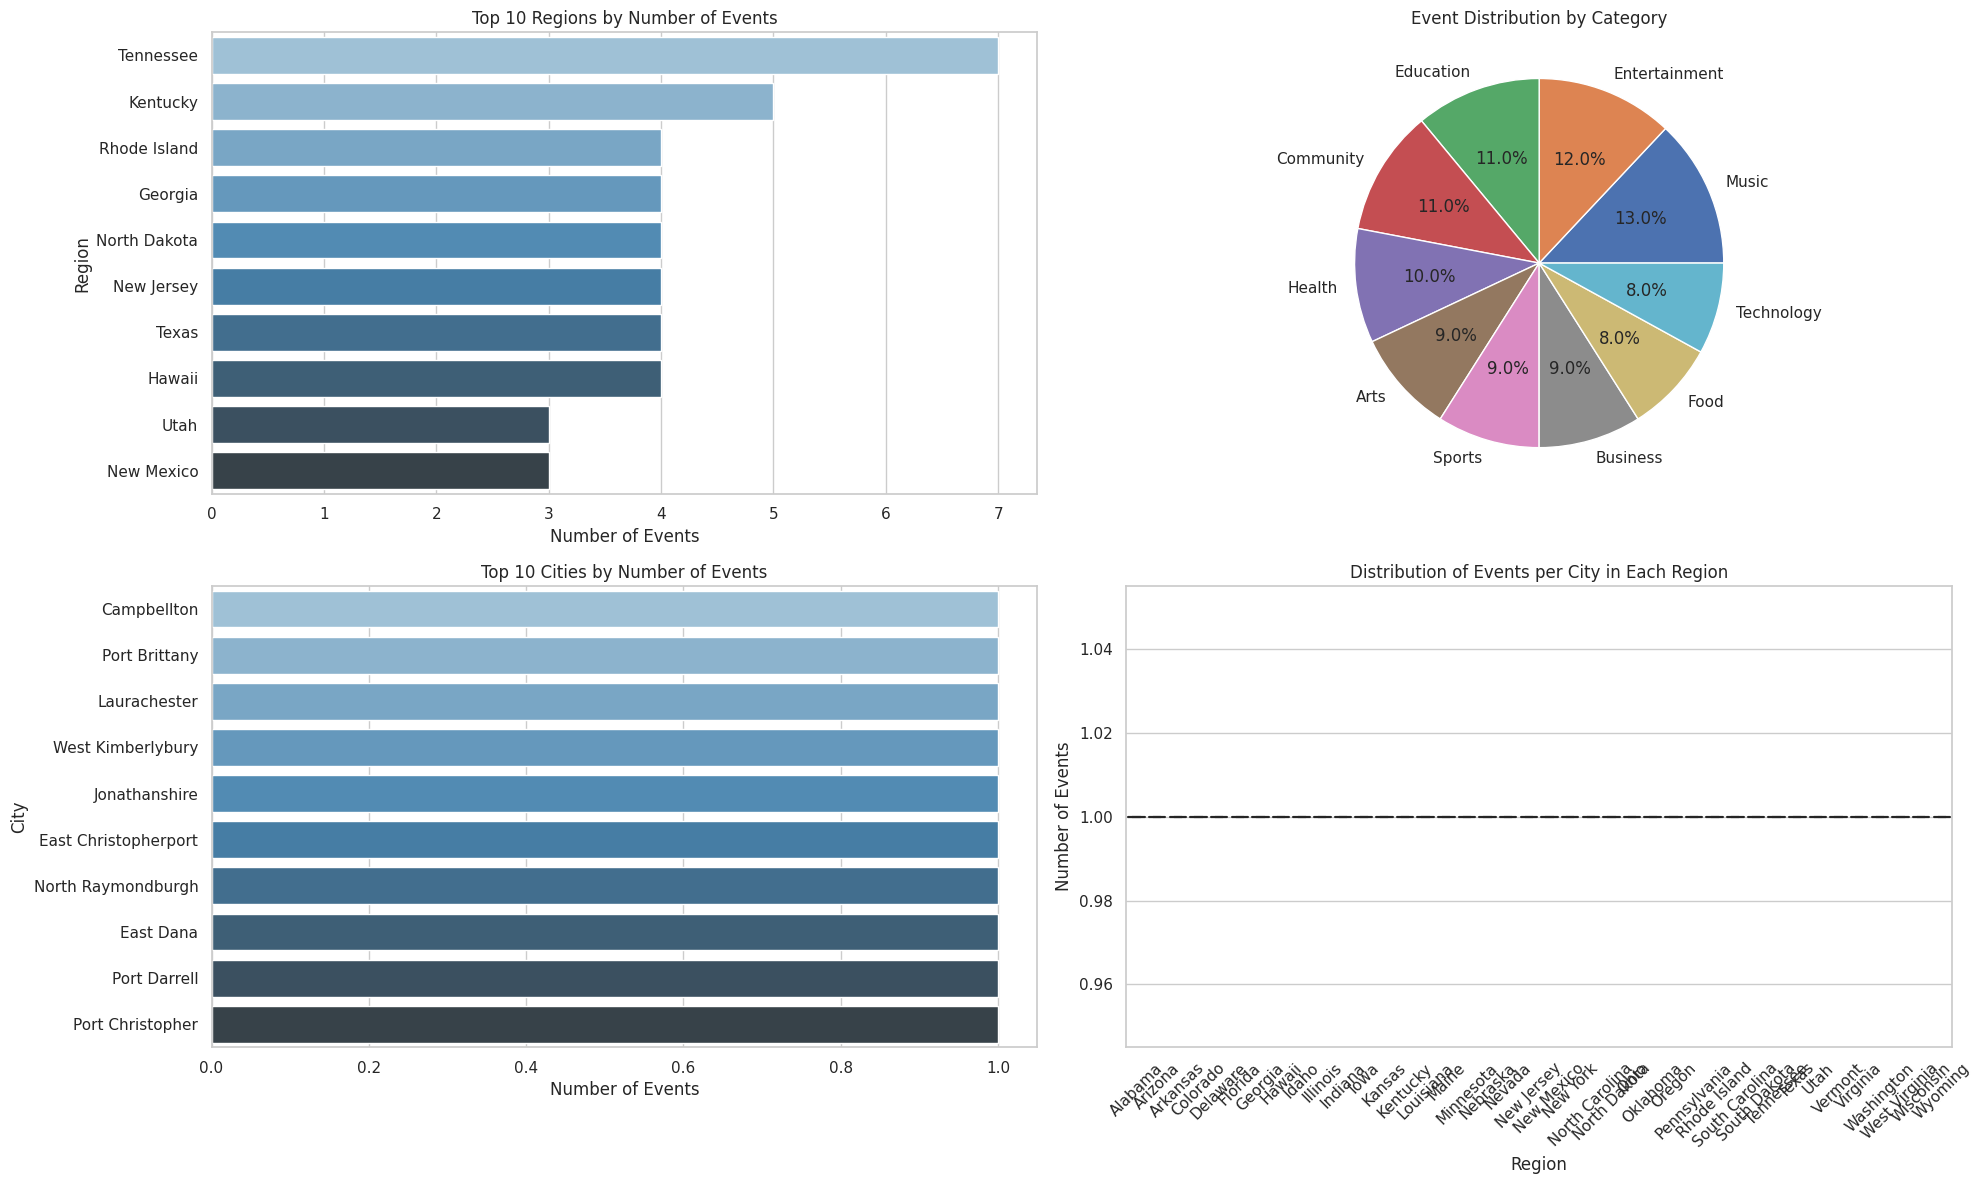

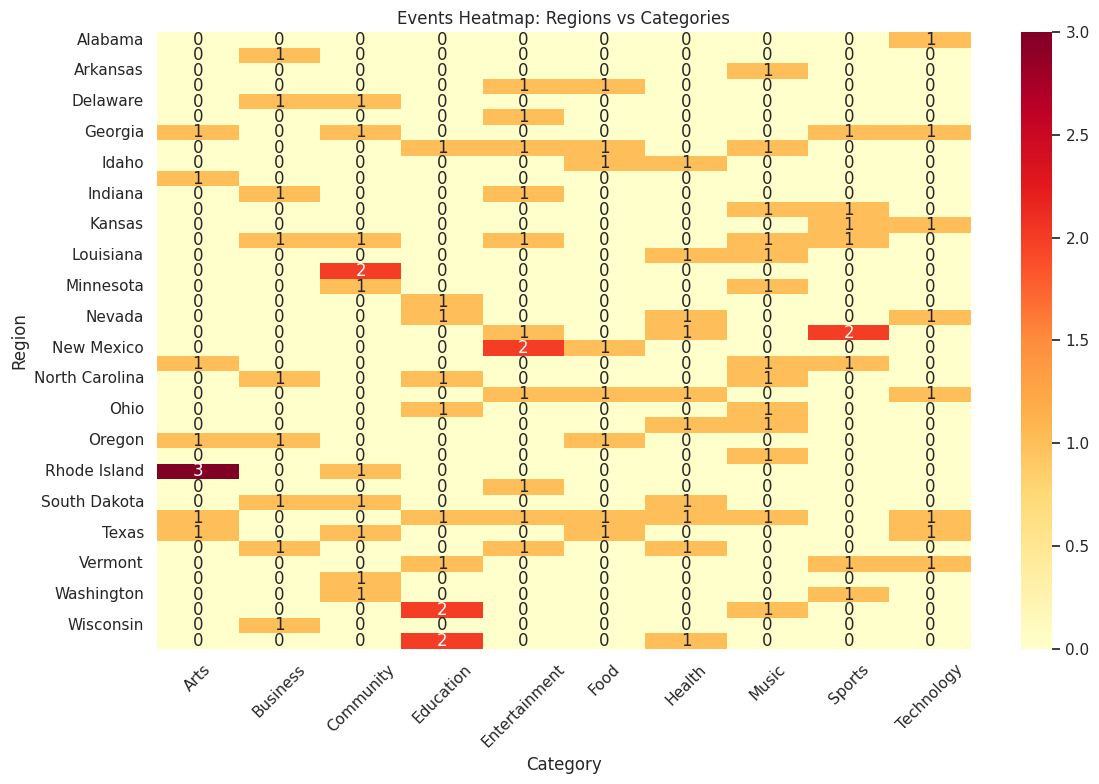

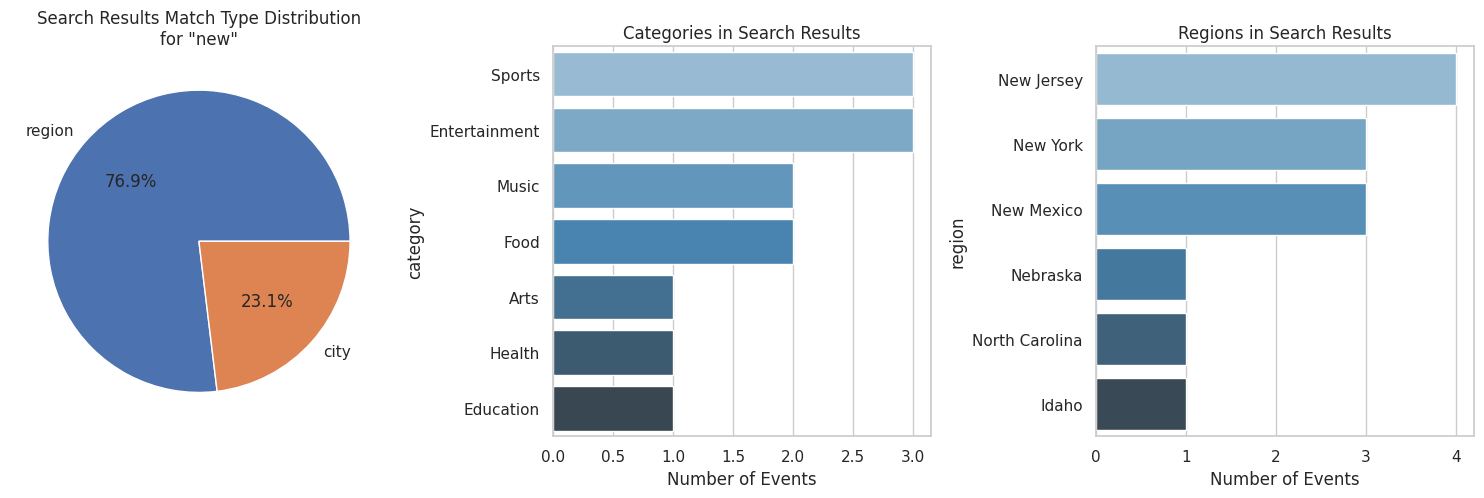

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict

def visualize_event_data(discovery_system: LocationBasedDiscovery):
    """
    Create visualizations for the LocationBasedDiscovery system output
    
    Args:
        discovery_system: Initialized LocationBasedDiscovery instance
    """
    # Use a modern style
    sns.set_theme(style="whitegrid")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Events by Region (Top 10)
    plt.subplot(2, 2, 1)
    region_counts = discovery_system.events_df['region'].value_counts().head(10)
    sns.barplot(x=region_counts.values, y=region_counts.index, palette="Blues_d")
    plt.title('Top 10 Regions by Number of Events')
    plt.xlabel('Number of Events')
    plt.ylabel('Region')
    
    # 2. Events by Category
    plt.subplot(2, 2, 2)
    category_counts = discovery_system.events_df['category'].value_counts()
    plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
    plt.title('Event Distribution by Category')
    
    # 3. Top Cities
    plt.subplot(2, 2, 3)
    city_counts = discovery_system.events_df['city'].value_counts().head(10)
    sns.barplot(x=city_counts.values, y=city_counts.index, palette="Blues_d")
    plt.title('Top 10 Cities by Number of Events')
    plt.xlabel('Number of Events')
    plt.ylabel('City')
    
    # 4. Events per Region Distribution
    plt.subplot(2, 2, 4)
    # Count events per region-city combination
    region_event_counts = discovery_system.events_df.groupby(['region', 'city']).size().reset_index(name='event_count')
    sns.boxplot(data=region_event_counts, x='region', y='event_count', palette="Blues")
    plt.xticks(rotation=45)
    plt.title('Distribution of Events per City in Each Region')
    plt.xlabel('Region')
    plt.ylabel('Number of Events')
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Heatmap of events across regions and categories
    plt.figure(figsize=(12, 8))
    region_category_pivot = pd.crosstab(
        discovery_system.events_df['region'],
        discovery_system.events_df['category']
    )
    sns.heatmap(region_category_pivot, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Events Heatmap: Regions vs Categories')
    plt.ylabel('Region')
    plt.xlabel('Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_search_results(discovery_system: LocationBasedDiscovery, search_term: str):
    """
    Visualize search results distribution
    
    Args:
        discovery_system: Initialized LocationBasedDiscovery instance
        search_term: Term used for searching events
    """
    results = discovery_system.search_events(search_term)
    
    if not results:
        print(f"No results found for search term: {search_term}")
        return
    
    # Convert results to DataFrame for easier visualization
    results_df = pd.DataFrame(results)
    
    # Create visualizations for search results
    fig = plt.figure(figsize=(15, 5))
    
    # 1. Match Type Distribution
    plt.subplot(1, 3, 1)
    match_type_counts = results_df['match_type'].value_counts()
    plt.pie(match_type_counts.values, labels=match_type_counts.index, autopct='%1.1f%%')
    plt.title(f'Search Results Match Type Distribution\nfor "{search_term}"')
    
    # 2. Category Distribution in Results
    plt.subplot(1, 3, 2)
    category_counts = results_df['category'].value_counts()
    sns.barplot(x=category_counts.values, y=category_counts.index, palette="Blues_d")
    plt.title('Categories in Search Results')
    plt.xlabel('Number of Events')
    
    # 3. Region Distribution in Results
    plt.subplot(1, 3, 3)
    region_counts = results_df['region'].value_counts()
    sns.barplot(x=region_counts.values, y=region_counts.index, palette="Blues_d")
    plt.title('Regions in Search Results')
    plt.xlabel('Number of Events')
    
    plt.tight_layout()
    plt.show()

# Example usage:

# Load your events data
events_df = pd.read_csv('events.csv')

# Initialize the discovery system
discovery = LocationBasedDiscovery(events_df)

# Create overall visualizations
visualize_event_data(discovery)

# Analyze specific search results
analyze_search_results(discovery, 'new')


In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

# Thompson Sampling Implementation
class ThompsonSamplingRecommender:
    def __init__(self, n_items):
        self.n_items = n_items
        self.successes = np.zeros(n_items)
        self.failures = np.zeros(n_items)

    def recommend(self):
        sampled_theta = np.random.beta(self.successes + 1, self.failures + 1)
        return np.argmax(sampled_theta)

    def update(self, item, reward):
        if reward == 1:
            self.successes[item] += 1
        else:
            self.failures[item] += 1

# Data Preprocessing Functions
def preprocess_events(events_df):
    """Preprocess events dataframe."""
    print("Initial events_df:")
    print(events_df.head())

    # Example preprocessing for tags
    events_df['tags'] = events_df['tags'].fillna('').str.lower()

    # Encode categories
    events_df = pd.get_dummies(events_df, columns=['category'], drop_first=True)
    print("Processed events_df:")
    print(events_df.head())
    return events_df

def preprocess_users(users_df):
    """Preprocess users dataframe."""
    print("Initial users_df:")
    print(users_df.head())

    # Gender encoding
    users_df['is_male'] = (users_df['gender'] == 'M').astype(int)
    print("Processed users_df:")
    print(users_df.head())
    return users_df

# Training Functions
def train_baseline_model(events_df, users_df, engagements_df):
    # Preprocess the data
    events_df = preprocess_events(events_df)
    users_df = preprocess_users(users_df)
   
    # Merge datasets
    merged_df = engagements_df.merge(users_df, on='user_id', how='left').merge(events_df, on='event_id', how='left')

    # Dynamically determine feature columns
    feature_cols = [col for col in merged_df.columns if col.startswith('category_') or col.startswith('interest_')]

    # Optional features: age and is_male
    if 'age' in merged_df.columns:
        feature_cols.append('age')
    if 'is_male' in merged_df.columns:
        feature_cols.append('is_male')

    print("Final feature columns:", feature_cols)

    # Extract features and target
    X = merged_df[feature_cols]
    y = (merged_df['engagements_score'] > 3).astype(int)  # Example threshold

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train a logistic regression model as a baseline
    model = LogisticRegression()
    model.fit(X_scaled, y)

    return model, scaler, feature_cols

def preprocess_users(users_df):
    # Split interests into individual columns
    users_df['interests'] = users_df['interests'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    unique_interests = set([interest for interests in users_df['interests'] for interest in interests])
    for interest in unique_interests:
        users_df[f'interest_{interest}'] = users_df['interests'].apply(lambda x: int(interest in x))

    # Drop the original interests column
    users_df.drop(columns=['interests'], inplace=True)

    print("Processed users_df:")
    print(users_df.head())
    return users_df


# Reinforcement Learning Pipeline
def adaptive_recommendation(events_df, users_df, engagements_df):
    print("Training baseline model...")
    model, scaler, feature_cols = train_baseline_model(events_df, users_df, engagements_df)

    print("Initializing Thompson Sampling...")
    n_items = events_df.shape[0]  # Number of events
    recommender = ThompsonSamplingRecommender(n_items=n_items)

    print("Simulating adaptive recommendations...")
    feedback_simulation_steps = 100
    for step in range(feedback_simulation_steps):
        # Recommend an event
        recommended_item = recommender.recommend()
        recommended_event = events_df.iloc[recommended_item]

        print(f"Step {step+1}: Recommended Event ID: {recommended_event['event_id']}")

        # Simulate user feedback (random for demo purposes)
        user_feedback = random.choice([0, 1])  # 0 = No engagement, 1 = Engaged

        # Update the recommender with feedback
        recommender.update(recommended_item, user_feedback)

    print("Final Successes and Failures:")
    print("Successes:", recommender.successes)
    print("Failures:", recommender.failures)

# Main Function
def main():
    print("Loading data...")
    events_df = pd.read_csv('/kaggle/working/events.csv')
    users_df = pd.read_csv('/kaggle/working/users.csv')
    engagements_df = pd.read_csv('/kaggle/working/engagements.csv')

    adaptive_recommendation(events_df, users_df, engagements_df)

if __name__ == "__main__":
    main()


Loading data...
Training baseline model...
Initial events_df:
                               event_id  \
0  352b24af-2a6c-4a57-889b-94fa7c69459e   
1  ace0b0ff-540d-4a71-8996-77c2eb8a0fb4   
2  7e9d27f1-31b8-427d-ad92-04d1cfa18b62   
3  b15b57d2-f13c-48da-9f03-61bfc2f73023   
4  c79dc288-b566-448b-b0ea-ce8c5b7397ca   

                               event_name       category  \
0        Reduced clear-thinking structure      Education   
1       Mandatory logistical installation           Arts   
2  Reverse-engineered scalable neural-net         Sports   
3      Visionary responsive collaboration      Community   
4         Up-sized client-driven extranet  Entertainment   

                                         description  \
0  Hundred face reality social man. Administratio...   
1  Key pay generation church.\nHope myself studen...   
2  Southern account traditional impact cold keep ...   
3  Arrive run call woman arrive vote. Poor contin...   
4  Employee whether brother now grow s

KeyError: 'engagements_score'